In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import itertools
import os

In [ ]:
'''
Data hasil simulasi sebelumnya tersedia online di drive dengan link:
https://drive.google.com/drive/folders/1-uuTJ4ULnKGOQ8KZQfYpzcc94t_4Xu4A?usp=sharing
'''

!gdown --folder --id 1-uuTJ4ULnKGOQ8KZQfYpzcc94t_4Xu4A -O /
os.chdir('/TMM Validation data')

os.listdir()

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Processing file 19fM6IwLh3ZQKO9EdXe1AmIFIuDJ9neBj validasipenghalangeckart_analitik.npz
Processing file 1wiuSnvBMFpysaoJGAHVBYTphpwXzoswj validasipenghalangeckart_dx0.1.npz
Processing file 1OAcBDr0u09R-vAWK1_PAA7fhDbk5ejzr validasipenghalangeckart_dx0.01.npz
Processing file 1ogH_etST13mS8QC8lJl5Ezrr9nwMtRkv validasipenghalangeckart_dx0.001.npz
Processing file 1q1WQZaBzX9ZEC2EByK-wtdbMCixh6PGb validasipenghalangganda_analitik.npz
Processing file 1yVnTluyCPrv9hL9kEOr2M45tjTwlFXWG validasipenghalangganda_dx0.1.npz
Processing file 1ggg-YlmQjcDnJtM_wBfn9ChSv4ES6OAu validasipenghalangganda_dx0.01.npz
Processing file 1VjDRoC7IgrQn0qlcVuhpdTu7bKEL793Z validasipenghalangganda_dx0.001.npz
Processing file 1X7JvFVgNNhri2zu1qEyZ3mLe2D9Hlihw validasipengha

['validasipenghalangtunggal_dx0.001.npz',
 'validasipenghalangeckart_dx0.1.npz',
 'validasipenghalangeckart_analitik.npz',
 'validasipenghalangganda_dx0.001.npz',
 'validasipenghalangganda_analitik.npz',
 'validasipenghalangganda_dx0.01.npz',
 'validasipenghalangganda_dx0.1.npz',
 'validasipenghalangtunggal_analitik.npz',
 'validasipenghalangtunggal_dx0.01.npz',
 'validasipenghalangeckart_dx0.001.npz',
 'validasipenghalangeckart_dx0.01.npz',
 'validasipenghalangtunggal_dx0.1.npz']

#Potensial Penghalang Tunggal

In [ ]:
import time
start = time.time()

In [ ]:
#Satuan sumbu x dalam nm
xmin = - 10
xmax = 20
dx = 0.001
nx = int((xmax-xmin)/dx) + 1
x = np.linspace(xmin, xmax, nx)
print(nx)

30001


In [ ]:
#Definisi bentuk potensial (eV)
L = 10  #nm
V = 1   #eV

def potensial(x):
  if 0 <= x < L:
    return V
  if x < 0 :
    return 0
  if x >= L :
    return 0

pot = np.vectorize(potensial)(x)

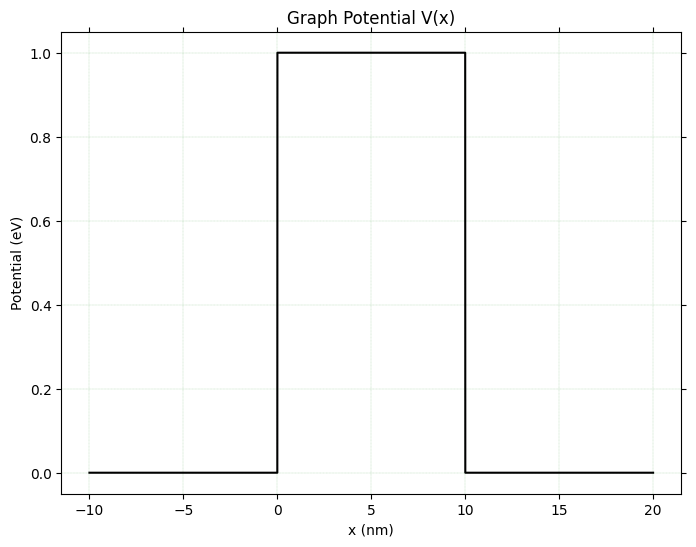

In [ ]:
#Plot
plt.figure(figsize=(8, 6))
plt.plot(x, pot, color='black')
plt.title(f"Graph Potential V(x)")
plt.xlabel("x (nm)")
plt.ylabel("Potential (eV)")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'green', linestyle = '-.', linewidth = 0.1)

plt.show()

In [ ]:
#Massa efektif dalam satuan me (massa elektron)
def mass_eff(x):
  return 1

mass_eff = np.vectorize(mass_eff)(x)

In [ ]:
#s adalah koefisien untuk merubah agar satuan k menjadi nm-1
hbar      = 1.054571817e-34     #Js
me        = 9.109534e-31        #Kg
eV_to_J   = 1.602176634e-19     #Merubah eV menjadi Joule
nm_to_m_2 = 1e-18               #agar satuan k menjadi nm-1
s = 2*me*eV_to_J*nm_to_m_2/(hbar**2)

"""Bilangan gelombang"""
@njit
def km(E, Vm, mfm):
  #Atasi nilai k=0 untuk E=V
  if E == Vm:
    Ec = E + 1e-15
    k  = np.sqrt(s*mfm*(Ec-Vm) + 0j)
  else:
    k  = np.sqrt(s*mfm*(E-Vm) + 0j)
  return k

"""Koefisien delta"""
@njit
def delta(E, Vm, mfm, Vm1, mfm1):
  k0 = km(E, Vm, mfm)
  k1 = km(E, Vm1, mfm1)
  delta1 = (k1/k0)*(mfm/mfm1)
  return delta1

"""Matriks Syarat Batas (D)"""
@njit
def D(E, Vm, mfm, Vm1, mfm1):
  delta1 = delta(E, Vm, mfm, Vm1, mfm1)
  a = 0.5*(1 + delta1)
  b = 0.5*(1 - delta1)
  c = b
  d = a
  nilai_D = np.array([[a, b], [c, d]])
  return nilai_D

"""Matriks Propagasi (P)"""
@njit
def P(E, Vm, mfm, dm):
  a = np.exp(-1j * km(E, Vm, mfm) * dm)
  b = 0
  c = 0
  d = np.exp( 1j * km(E, Vm, mfm) * dm)
  nilai_P = np.array([[a, b], [c, d]])
  return nilai_P

In [ ]:
"""Perhitungan Koefisien Transmisi """
@njit
def nilai(E):
  M = np.identity(2, dtype=np.complex128)

  #Matriks Syarat Batas Awal
  M = M @ D(E, pot[0], mass_eff[0], pot[1], mass_eff[1])

  for i in range(1, nx-1):
    matriks_P = P(E, pot[i], mass_eff[i], dx)
    matriks_D = D(E, pot[i], mass_eff[i], pot[i+1], mass_eff[i+1])
    M= M @ matriks_P @ matriks_D

  #Nilai koefisien trasmisi
  A = np.abs(M[0,0])
  rasio_meff = mass_eff[0]/mass_eff[-1]
  kR   = km(E, pot[-1], mass_eff[-1])
  kL   = km(E, pot[0], mass_eff[0])
  rasio_koef = (np.abs(kR))/(np.abs(kL))
  T = rasio_meff * rasio_koef / (A*A)

  return T

In [ ]:
E = np.arange(0.9, 1.1, 0.001)
E = E[E !=1]

In [ ]:
nilai_transmisi = [nilai(i) for i in E]

In [ ]:
#Analitik
V0 = V

#Fungsi koefisien transmisi analitik
def transmisi_analitik(E):
  if E >= V0:
    if E == V0:
      E = E + 1e-15
    k1 = np.sqrt(s * E)
    k2 = np.sqrt(s * (E - V0))
    T = 1 / (1 + (V0**2 / (4 * E * (E - V0))) * np.sin(k2 * L)**2)
  if E < V0:
    k1 = np.sqrt(s * E)
    kappa = np.sqrt(s * (V0 - E))
    T = 1 / (1 + (V0**2 / (4 * E * (V0 - E))) * np.sinh(kappa * L)**2)
  return T

T_analitik = [transmisi_analitik(i) for i in E]

In [ ]:
#save npz
filename = f"validasipenghalangtunggal_dx{dx}.npz"
np.savez(filename, E=E, nilai_transmisi=nilai_transmisi)

filename1 = f"validasipenghalangtunggal_analitik.npz"
np.savez(filename1, E=E, nilai_transmisi=T_analitik)

In [ ]:
end = time.time()
print(f"\nTotal waktu eksekusi: {end - start:.5f} detik")


Total waktu eksekusi: 11.44192 detik


#Validasi Potensial Penghalang Tunggal

In [ ]:
# Load data dari file npz
dx = [0.1, 0.01, 0.001]
for i in dx:
  dx = i
  filename = f"validasipenghalangtunggal_dx{dx}.npz"
  data = np.load(filename)
  variable = {f"{var}_dx{str(dx).replace('.', '_')}": data[var] for var in ['E', 'nilai_transmisi']}
  globals().update(variable)

# Load data analitik
filename = f"validasipenghalangtunggal_analitik.npz"
data = np.load(filename)
variable = {f"{var}": data[var] for var in ['E', 'nilai_transmisi']}
globals().update(variable)

In [ ]:
E = E_dx0_1
T1 = nilai_transmisi_dx0_1
T2 = nilai_transmisi_dx0_01
T3 = nilai_transmisi_dx0_001
T_analitik = nilai_transmisi

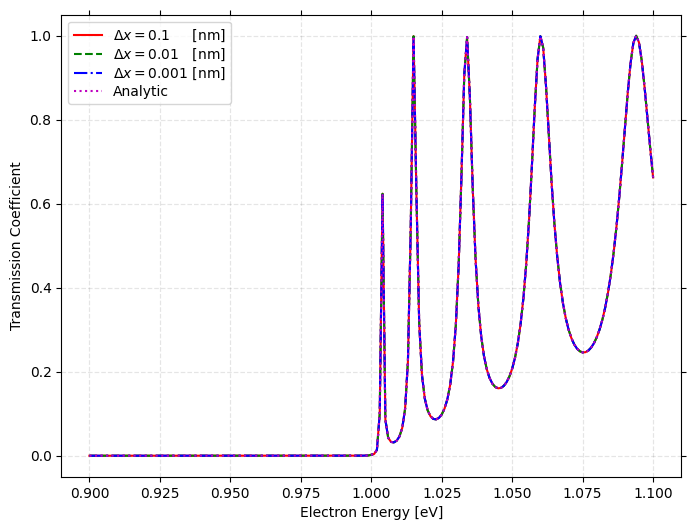

In [ ]:
colors = itertools.cycle(['r', 'g', 'b', 'm', 'y', 'k'])
linestyles = itertools.cycle(['-', '--', '-.', ':'])

plt.figure(figsize=(8, 6))
plt.plot(E, T1, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.1$     [nm]')
plt.plot(E, T2, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.01$   [nm]')
plt.plot(E, T3, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.001$ [nm]')
plt.plot(E, T_analitik, color='m', linestyle=':', label='Analytic')

#plt.title("Single Barrier Potential", fontsize=10)
plt.xlabel("Electron Energy [eV]")
plt.ylabel("Transmission Coefficient")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha = 0.1)
plt.legend(labelspacing=0.2, loc = 'upper left')

plt.show()

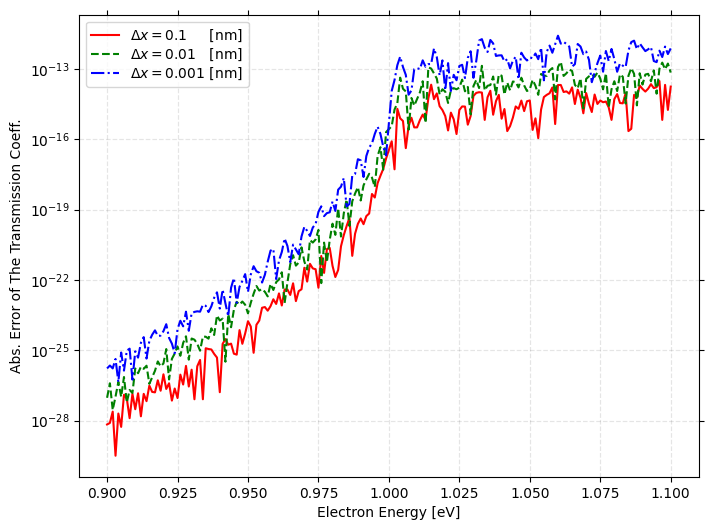

In [ ]:
colors = itertools.cycle(['r', 'g', 'b', 'm', 'y', 'k'])
linestyles = itertools.cycle(['-', '--', '-.', ':'])

#Ralat
errT1 = np.abs(np.array(T1) - np.array(T_analitik))
errT2 = np.abs(np.array(T2) - np.array(T_analitik))
errT3 = np.abs(np.array(T3) - np.array(T_analitik))

plt.figure(figsize=(8, 6))
plt.plot(E, errT1, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.1$     [nm]')
plt.plot(E, errT2, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.01$   [nm]')
plt.plot(E, errT3, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.001$ [nm]')

#plt.title("Absolute Error in The Single Barrier Potential", fontsize=10)
plt.xlabel("Electron Energy [eV]")
plt.ylabel("Abs. Error of The Transmission Coeff.")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha = 0.1)
plt.legend(labelspacing=0.2, loc='upper left')#, frameon = False)
plt.yscale('log')

plt.show()

In [ ]:
print(E[149], (errT1[149]), (errT2[149]), (errT3[149]))

1.0500000000000003 4.496403249731884e-15 1.3489209749195652e-14 3.090028233287967e-13


#Potensial Penghalang Ganda

In [ ]:
import time
start = time.time()

In [ ]:
#Validasi Potensial Penghalang Ganda
#Satuan dalam nm untuk dimensi x
left = 9
b = 4
a = 4
right = 9
#Satuan sumbu x dalam nm
xmin = - left - a
xmax = b + a + right
dx = 0.1
nx = int((xmax-xmin)/dx) + 1
x = np.linspace(xmin, xmax, nx)
print(nx)

301


In [ ]:
#Definisi bentuk potensial (eV)
V = 1   #eV

def potensial(x):
  if -a <= x < 0:
    return V
  if b <= x < b+a:
    return V
  else:
    return 0

pot = np.vectorize(potensial)(x)

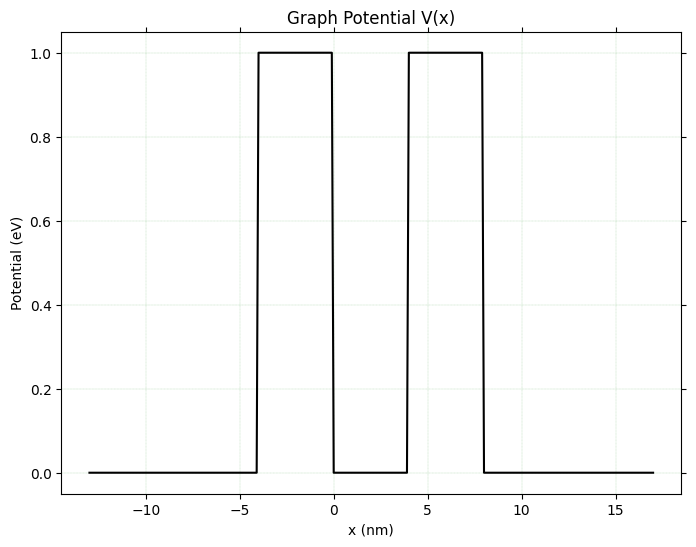

In [ ]:
#Plot
plt.figure(figsize=(8, 6))
plt.plot(x, pot, color='black')
plt.title(f"Graph Potential V(x)")
plt.xlabel("x (nm)")
plt.ylabel("Potential (eV)")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'green', linestyle = '-.', linewidth = 0.1)

plt.show()

In [ ]:
#Massa efektif dalam satuan me (massa elektron)
def mass_eff(x):
  return 1

mass_eff = np.vectorize(mass_eff)(x)

In [ ]:
#s adalah koefisien untuk merubah agar satuan k menjadi nm-1
hbar      = 1.054571817e-34     #Js
me        = 9.109534e-31        #Kg
eV_to_J   = 1.602176634e-19     #Merubah eV menjadi Joule
nm_to_m_2 = 1e-18               #agar satuan k menjadi nm-1
s = 2*me*eV_to_J*nm_to_m_2/(hbar**2)

"""Bilangan gelombang"""
@njit
def km(E, Vm, mfm):
  #Atasi nilai k=0 untuk E=V
  if E == Vm:
    Ec = E + 1e-15
    k  = np.sqrt(s*mfm*(Ec-Vm) + 0j)
  else:
    k  = np.sqrt(s*mfm*(E-Vm) + 0j)
  return k

"""Koefisien delta"""
@njit
def delta(E, Vm, mfm, Vm1, mfm1):
  k0 = km(E, Vm, mfm)
  k1 = km(E, Vm1, mfm1)
  delta1 = (k1/k0)*(mfm/mfm1)
  return delta1

"""Matriks Syarat Batas (D)"""
@njit
def D(E, Vm, mfm, Vm1, mfm1):
  delta1 = delta(E, Vm, mfm, Vm1, mfm1)
  a = 0.5*(1 + delta1)
  b = 0.5*(1 - delta1)
  c = b
  d = a
  nilai_D = np.array([[a, b], [c, d]])
  return nilai_D

"""Matriks Propagasi (P)"""
@njit
def P(E, Vm, mfm, dm):
  a = np.exp(-1j * km(E, Vm, mfm) * dm)
  b = 0
  c = 0
  d = np.exp( 1j * km(E, Vm, mfm) * dm)
  nilai_P = np.array([[a, b], [c, d]])
  return nilai_P

In [ ]:
"""Perhitungan Koefisien Transmisi """
@njit
def nilai(E):
  M = np.identity(2, dtype=np.complex128)

  #Matriks Syarat Batas Awal
  M = M @ D(E, pot[0], mass_eff[0], pot[1], mass_eff[1])

  for i in range(1, nx-1):
    matriks_P = P(E, pot[i], mass_eff[i], dx)
    matriks_D = D(E, pot[i], mass_eff[i], pot[i+1], mass_eff[i+1])
    M= M @ matriks_P @ matriks_D

  #Nilai koefisien trasmisi
  A = np.abs(M[0,0])
  rasio_meff = mass_eff[0]/mass_eff[-1]
  kR   = km(E, pot[-1], mass_eff[-1])
  kL   = km(E, pot[0], mass_eff[0])
  rasio_koef = (np.abs(kR))/(np.abs(kL))
  T = rasio_meff * rasio_koef / (A*A)

  return T

In [ ]:
E = np.arange(0.9, 1.1, 0.001)
E = E[E !=1]
nilai_transmisi = [nilai(i) for i in E]

In [ ]:
#analitik
V0 = V

def transmisi_analitik(E):
  if (E == V0).any():
    E = E + 1e-15

  k1 = np.sqrt(s * E)
  k2 = np.sqrt(s * (V0 - E) + 0j)

  alpha = k1**2 - k2**2
  beta = k1**2 + k2**2
  gamma = k1 * k2

  C1 = 4 * gamma**2 * np.cosh(2 * a * k2) * np.cos(b * k1) - 2 * alpha * gamma * np.sinh(2 * a * k2) * np.sin(b * k1)
  C2 = alpha**2 * np.cosh(2 * a * k2) * np.sin(b * k1) - 2 * alpha * gamma * np.sinh(2 * a * k2) * np.cos(b * k1) - beta**2 * np.sin(b * k1)
  C3 = 4 * gamma**2

  T = (C3**2) / (C1**2 + C2**2)
  T = np.abs(T)
  return T

T_analitik = transmisi_analitik(E)

In [ ]:
#save npz
filename = f"validasipenghalangganda_dx{dx}.npz"
np.savez(filename, E=E, nilai_transmisi=nilai_transmisi)

filename1 = f"validasipenghalangganda_analitik.npz"
np.savez(filename1, E=E, nilai_transmisi=T_analitik)

In [ ]:
end = time.time()
print(f"\nTotal waktu eksekusi: {end - start:.5f} detik")


Total waktu eksekusi: 3.78157 detik


#Validasi Potensial Penghalang Ganda

In [ ]:
# Load data dari file npz
dx = [0.1, 0.01, 0.001]
for i in dx:
  dx = i
  filename = f"validasipenghalangganda_dx{dx}.npz"
  data = np.load(filename)
  variable = {f"ganda_{var}_dx{str(dx).replace('.', '_')}": data[var] for var in ['E', 'nilai_transmisi']}
  globals().update(variable)

# Load data analitik
filename = f"validasipenghalangganda_analitik.npz"
data = np.load(filename)
variable = {f"ganda_{var}": data[var] for var in ['E', 'nilai_transmisi']}
globals().update(variable)

In [ ]:
E_ganda = ganda_E_dx0_1
T1_ganda = ganda_nilai_transmisi_dx0_1
T2_ganda = ganda_nilai_transmisi_dx0_01
T3_ganda = ganda_nilai_transmisi_dx0_001
T_ganda = ganda_nilai_transmisi

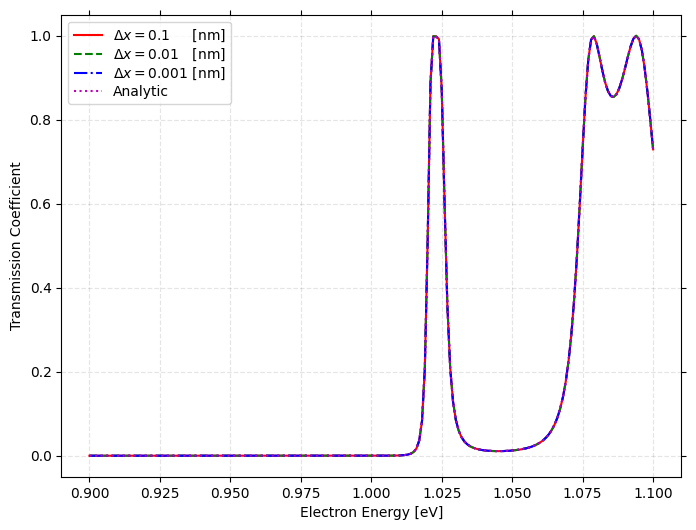

In [ ]:
colors = itertools.cycle(['r', 'g', 'b', 'm', 'y', 'k'])
linestyles = itertools.cycle(['-', '--', '-.', ':'])

plt.figure(figsize=(8, 6))
plt.plot(E_ganda, T1_ganda, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.1$     [nm]')
plt.plot(E_ganda, T2_ganda, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.01$   [nm]')
plt.plot(E_ganda, T3_ganda, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.001$ [nm]')
plt.plot(E_ganda, T_ganda, color='m', linestyle=':', label='Analytic')

#plt.title("Double Barrier Potential", fontsize=10)
plt.xlabel("Electron Energy [eV]")
plt.ylabel("Transmission Coefficient")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha = 0.1)
plt.legend(labelspacing=0.2, loc = 'upper left')

plt.show()

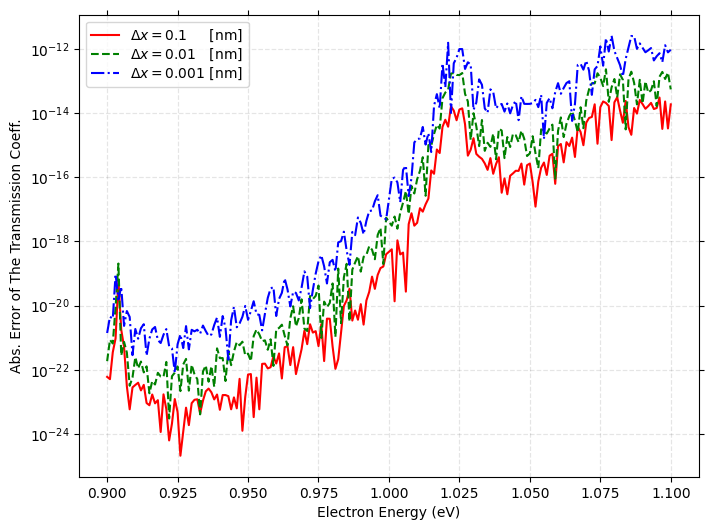

In [ ]:
colors = itertools.cycle(['r', 'g', 'b', 'm', 'y', 'k'])
linestyles = itertools.cycle(['-', '--', '-.', ':'])

#Ralat
errT1_ganda = np.abs(np.array(T1_ganda) - np.array(T_ganda))
errT2_ganda = np.abs(np.array(T2_ganda) - np.array(T_ganda))
errT3_ganda = np.abs(np.array(T3_ganda) - np.array(T_ganda))

plt.figure(figsize=(8, 6))
plt.plot(E_ganda, errT1_ganda, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.1$     [nm]')
plt.plot(E_ganda, errT2_ganda, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.01$   [nm]')
plt.plot(E_ganda, errT3_ganda, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.001$ [nm]')

#plt.title("Absolute Error in The Double Barrier Potential", fontsize=10)
plt.xlabel("Electron Energy (eV)")
plt.ylabel("Abs. Error of The Transmission Coeff.")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha = 0.1)
plt.legend(labelspacing=0.2, loc='upper left')#, frameon = False)
plt.yscale('log')

plt.show()

In [ ]:
print(E[149], (errT1_ganda[149]), (errT2_ganda[149]), (errT3_ganda[149]))

1.0500000000000003 2.671474153004283e-16 5.551115123125783e-16 1.94393112717961e-14


#Potensial Penghalang Eckart

In [ ]:
import time
start = time.time()

In [ ]:
#Validasi Potensial Penghalang Eckart
#Satuan sumbu x dalam nm
xmin = -15
xmax = 15
dx = 0.001
nx = int((xmax-xmin)/dx) + 1
x = np.linspace(xmin, xmax, nx)
print(nx)

30001


In [ ]:
#Definisi bentuk potensial eckart(eV)
l0  = 1     #nm
V0  = 1     #eV
c   = 1     #konstanta potenial eckart

def potensial(x):
  kons1 = np.exp(x/l0)
  V = V0 * (1-((1 - kons1)/(1 + c*kons1))**2)
  return V

pot = np.vectorize(potensial)(x)

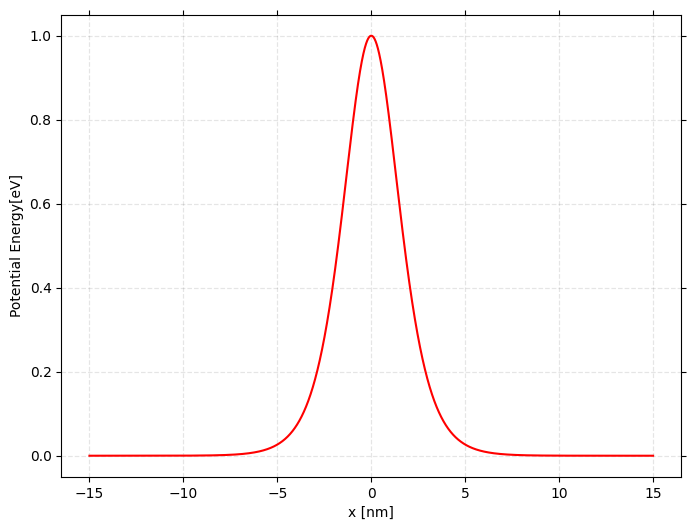

In [ ]:
#Plot
plt.figure(figsize=(8, 6))
plt.plot(x, pot, color='r')
#plt.title(f"Graph Symmetric Eckart Barrier Potential", fontsize=10)
plt.xlabel("x [nm]")
plt.ylabel("Potential Energy[eV]")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha = 0.1)

plt.show()

In [ ]:
#Massa efektif dalam satuan me (massa elektron)
def mass_eff(x):
  return 1

mass_eff = np.vectorize(mass_eff)(x)

In [ ]:
#s adalah koefisien untuk merubah agar satuan k menjadi nm-1
hbar      = 1.054571817e-34     #Js
me        = 9.109534e-31        #Kg
eV_to_J   = 1.602176634e-19     #Merubah eV menjadi Joule
nm_to_m_2 = 1e-18               #agar satuan k menjadi nm-1
s = 2*me*eV_to_J*nm_to_m_2/(hbar**2)

"""Bilangan gelombang"""
@njit
def km(E, Vm, mfm):
  #Atasi nilai k=0 untuk E=V
  if E == Vm:
    Ec = E + 1e-15
    k  = np.sqrt(s*mfm*(Ec-Vm) + 0j)
  else:
    k  = np.sqrt(s*mfm*(E-Vm) + 0j)
  return k

"""Koefisien delta"""
@njit
def delta(E, Vm, mfm, Vm1, mfm1):
  k0 = km(E, Vm, mfm)
  k1 = km(E, Vm1, mfm1)
  delta1 = (k1/k0)*(mfm/mfm1)
  return delta1

"""Matriks Syarat Batas (D)"""
@njit
def D(E, Vm, mfm, Vm1, mfm1):
  delta1 = delta(E, Vm, mfm, Vm1, mfm1)
  a = 0.5*(1 + delta1)
  b = 0.5*(1 - delta1)
  c = b
  d = a
  nilai_D = np.array([[a, b], [c, d]])
  return nilai_D

"""Matriks Propagasi (P)"""
@njit
def P(E, Vm, mfm, dm):
  a = np.exp(-1j * km(E, Vm, mfm) * dm)
  b = 0
  c = 0
  d = np.exp( 1j * km(E, Vm, mfm) * dm)
  nilai_P = np.array([[a, b], [c, d]])
  return nilai_P

In [ ]:
"""Perhitungan Koefisien Transmisi """
@njit
def nilai(E):
  M = np.identity(2, dtype=np.complex128)

  #Matriks Syarat Batas Awal
  M = M @ D(E, pot[0], mass_eff[0], pot[1], mass_eff[1])

  for i in range(1, nx-1):
    matriks_P = P(E, pot[i], mass_eff[i], dx)
    matriks_D = D(E, pot[i], mass_eff[i], pot[i+1], mass_eff[i+1])
    M= M @ matriks_P @ matriks_D

  #Nilai koefisien trasmisi
  A = np.abs(M[0,0])
  rasio_meff = mass_eff[0]/mass_eff[-1]
  kR   = km(E, pot[-1], mass_eff[-1])
  kL   = km(E, pot[0], mass_eff[0])
  rasio_koef = (np.abs(kR))/(np.abs(kL))
  T = rasio_meff * rasio_koef / (A*A)

  return T

In [ ]:
E = np.arange(0.9, 1.1, 0.001)
nilai_transmisi = [nilai(i) for i in E]

In [ ]:
#analitik
def transmisi_analitik(E):
  E     = E*eV_to_J
  V     = V0*eV_to_J
  l     = l0*1e-9
  delta = hbar**2/(2*me*l**2)
  cquad = c*c
  bquad = 1/cquad
  fquad = E/delta
  qquad = V/delta
  b     = np.sqrt(bquad)
  f     = np.sqrt(fquad)
  q     = np.sqrt(qquad)
  s     = np.sqrt(fquad + (bquad-1)*qquad)
  g     = np.sqrt(qquad*(b+1)**2 - (1/4))

  c1 = np.sinh(2*np.pi*f)
  c2 = np.sinh(2*np.pi*s)
  c3 = np.cosh(np.pi*(f+s+g))
  c4 = np.cosh(np.pi*(f+s-g))

  T = c1*c2/(c3*c4)

  return T

T_analitik = transmisi_analitik(E)

In [ ]:
#save npz
filename = f"validasipenghalangeckart_dx{dx}.npz"
np.savez(filename, E=E, nilai_transmisi=nilai_transmisi)

filename1 = f"validasipenghalangeckart_analitik.npz"
np.savez(filename1, E=E, nilai_transmisi=T_analitik)

In [ ]:
end = time.time()
print(f"\nTotal waktu eksekusi: {end - start:.5f} detik")


Total waktu eksekusi: 11.71408 detik


#Validasi Potensial Penghalang Eckart

In [ ]:
# Load data dari file npz
dx = [0.1, 0.01, 0.001]
for i in dx:
  dx = i
  filename = f"validasipenghalangeckart_dx{dx}.npz"
  data = np.load(filename)
  variable = {f"eckart_{var}_dx{str(dx).replace('.', '_')}": data[var] for var in ['E', 'nilai_transmisi']}
  globals().update(variable)

# Load data analitik
filename = f"validasipenghalangeckart_analitik.npz"
data = np.load(filename)
variable = {f"eckart_{var}": data[var] for var in ['E', 'nilai_transmisi']}
globals().update(variable)

In [ ]:
E_eckart   = eckart_E_dx0_1
T1_eckart  = eckart_nilai_transmisi_dx0_1
T2_eckart  = eckart_nilai_transmisi_dx0_01
T3_eckart  = eckart_nilai_transmisi_dx0_001
T_eckart   = eckart_nilai_transmisi

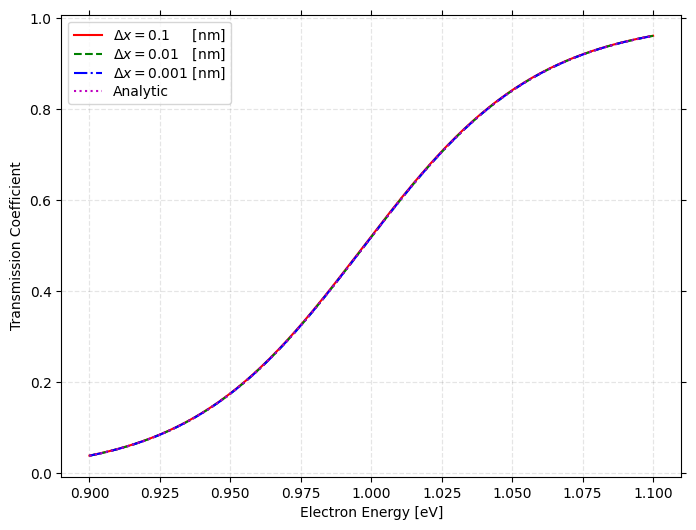

In [ ]:
colors = itertools.cycle(['r', 'g', 'b', 'm', 'y', 'k'])
linestyles = itertools.cycle(['-', '--', '-.', ':'])

plt.figure(figsize=(8, 6))
plt.plot(E_eckart, T1_eckart, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.1$     [nm]')
plt.plot(E_eckart, T2_eckart, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.01$   [nm]')
plt.plot(E_eckart, T3_eckart, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.001$ [nm]')
plt.plot(E_eckart, T_eckart, color='m', linestyle=':', label='Analytic')

#plt.title("Symmetric Eckart Barrier Potential", fontsize=10)
plt.xlabel("Electron Energy [eV]")
plt.ylabel("Transmission Coefficient")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha = 0.1)
plt.legend(labelspacing=0.2, loc = 'upper left')

plt.show()

In [ ]:
r'$\Delta$$x=0.1$     [nm]'
r'$\Delta$$x=0.01$   [nm]'
r'$\Delta$$x=0.001$ [nm]'

'$\\Delta$$x=0.001$ [nm]'

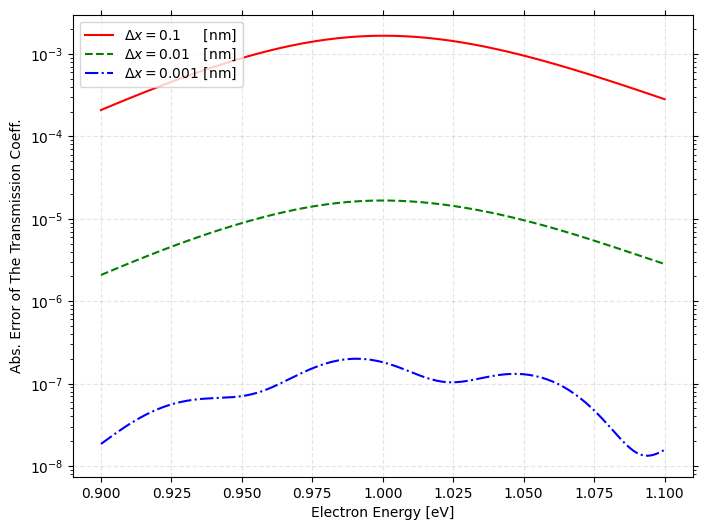

In [ ]:
colors = itertools.cycle(['r', 'g', 'b', 'm', 'y', 'k'])
linestyles = itertools.cycle(['-', '--', '-.', ':'])

#Ralat
errT1_eckart = np.abs(np.array(T1_eckart) - np.array(T_eckart))
errT2_eckart = np.abs(np.array(T2_eckart) - np.array(T_eckart))
errT3_eckart = np.abs(np.array(T3_eckart) - np.array(T_eckart))

plt.figure(figsize=(8, 6))
plt.plot(E_eckart, errT1_eckart, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.1$     [nm]')
plt.plot(E_eckart, errT2_eckart, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.01$   [nm]')
plt.plot(E_eckart, errT3_eckart, color=next(colors), linestyle=next(linestyles), label=r'$\Delta$$x=0.001$ [nm]')

#plt.title("Absolute Error in The Symmetric Eckart Barrier Potential", fontsize=10)
plt.xlabel("Electron Energy [eV]")
plt.ylabel("Abs. Error of The Transmission Coeff.")

ax = plt.gca()
ax.tick_params(top=True, right=True, which='both')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.9, alpha = 0.1)
plt.legend(labelspacing=0.2, loc='upper left')#, frameon = False)
plt.yscale('log')

plt.show()

In [ ]:
print(E[149], (errT1_eckart[149]), (errT2_eckart[149]), (errT3_eckart[149]))

1.0500000000000003 0.0009744967501844615 9.802568118000288e-06 1.305356130965052e-07
